In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt

In [2]:
def getInfo(str_in):
    grouped = re.findall('"(.*)" "(.*)" "(.*)"', str_in)
    if len(grouped) == 0:
        return None
    return grouped[0]

In [3]:
def getCharacterDictFromFile(file_name):
    df = pd.read_fwf(file_name)
    lines = []
    for i in df['"character" "dialogue"']:
        lines.append(getInfo(i))
    character_dict = {}
    for line in lines:
        if line is None:
            continue
        if line[1] in character_dict:
            character_dict[line[1]].append(line)
        else :
            character_dict[line[1]] = [line]
    return character_dict

In [4]:
character_dictIV = getCharacterDictFromFile('./Transcripts/SW_EpisodeIV.txt')
character_dictV = getCharacterDictFromFile('./Transcripts/SW_EpisodeV.txt')
character_dictVI = getCharacterDictFromFile('./Transcripts/SW_EpisodeVI.txt')

In [5]:
character_dictIV

{'ASTRO-OFFICER': [('868',
   'ASTRO-OFFICER',
   "We count thirty Rebel ships, Lord Vader.  But they're so small they're evading our turbo-lasers!")],
 'AUNT BERU': [('168', 'AUNT BERU', 'Luke?  Luke!  Come to dinner!'),
  ('192', 'AUNT BERU', 'Where are you going?'),
  ('194',
   'AUNT BERU',
   "Owen, he can't stay here forever.  Most of his friends have gone.  It means so much to him."),
  ('196',
   'AUNT BERU',
   "Luke's just not a farmer, Owen.  He has too much of his father in him."),
  ('211',
   'AUNT BERU',
   'He said he had some things to do before he started today, so he left early.'),
  ('213', 'AUNT BERU', 'I think so.')],
 'BARTENDER': [('326', 'BARTENDER', "We don't serve their kind here!"),
  ('328',
   'BARTENDER',
   "Your droids. They'll have to wait outside.  We don't want them here."),
  ('339', 'BARTENDER', 'No blasters!  No blaster!')],
 'BASE VOICE': [('984',
   'BASE VOICE',
   "His computer's off.  Luke, you switched off your targeting computer.  What's wr

In [6]:
def getCharacterTalk(character_dict):
    character_talk = {}
    for character in character_dict:
        character_talk[character] = len(character_dict[character])
    sorted_character_talk = sorted (character_talk.items(), key=lambda x: x[1], reverse=True)
    return sorted_character_talk

In [7]:
character_talkIV = getCharacterTalk(character_dictIV)    
character_talkV = getCharacterTalk(character_dictV)    
character_talkVI = getCharacterTalk(character_dictVI)    

In [8]:
def drawTalkGraph(talk):
    x = []
    y = []
    for i in talk:
        x.append(i[0])
        y.append(i[1])

    plt.figure(figsize = (20,5))
    plt.title("")
    plt.bar(x,y)
    plt.xticks(rotation=90)
    plt.show()

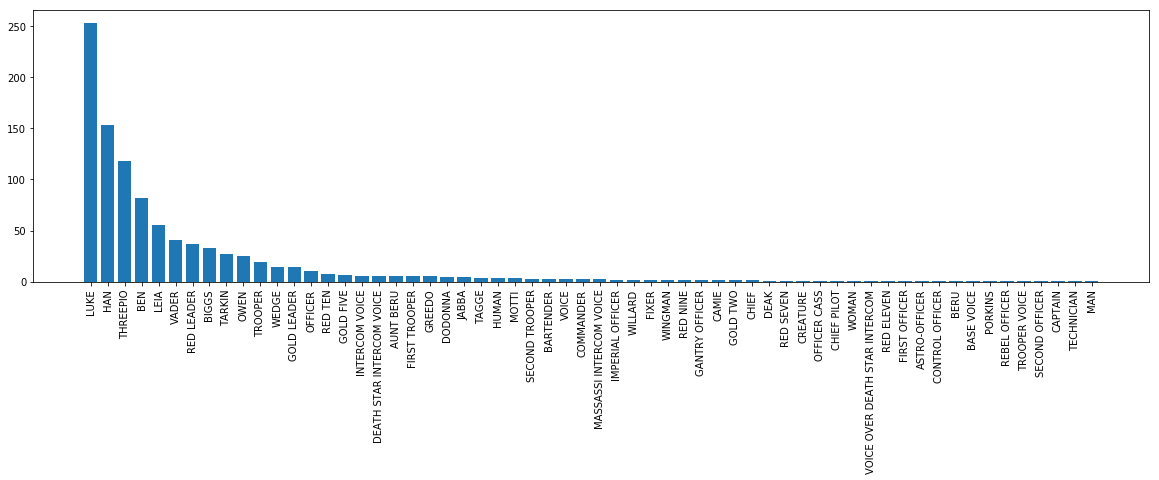

In [9]:
drawTalkGraph(character_talkIV)

# NLTK 

In [10]:
import nltk
import numpy as np
import io

In [11]:
def tokenize(text):
    text = text.encode('ascii','ignore')

    # Remove all punctuation and numbers
    regexp = '[^\W]+'
    cleanTokens = re.findall(regexp, text)
    
    # Remove all words of length 1 and set lowercase
    cleanTokens = [w.lower() for w in cleanTokens if len(w) > 1]
    stopwords = nltk.corpus.stopwords.words('english')

    # Remove stopwords
    cleanTokens = [w for w in cleanTokens if w not in stopwords]
    
    return cleanTokens

In [12]:
def read_file(filename):
    with io.open('./'+filename, encoding='utf-8') as f:
        return f.read()

# Read word list and extract all the various categories
mt_word_list = read_file('Sentiment_Data_Set_S1.txt').splitlines()[3:]
sentiment_dict = {}

# Iterating over every word in list
for row in mt_word_list[1:]:
    cols = row.split("\t")
    word = cols[0]
    # cols[2] is the happiness score avg.
    sentiment_dict[word] = cols[2]

def get_sentiment(tokens):
    sentiment_sum = 0.0
    count = 0
    for token in tokens:
        if token in sentiment_dict:
            sentiment_sum += float(sentiment_dict[token]) # happiness avg
            count += 1
    if count == 0:
        return None
    avg_hap = sentiment_sum / float(count)
    return avg_hap

In [13]:
def getSentimentsForCharacter(character, character_dict):
    time = []
    sentiments = []
    if character not in character_dict:
        return None
    c = character_dict[character]
    for line in c:
        tokens = tokenize(line[2])
        sentiment = get_sentiment(tokens)
        if(sentiment) is None:
            continue
        time.append(int(line[0]))
        sentiments.append(get_sentiment(tokens))
    return time, sentiments

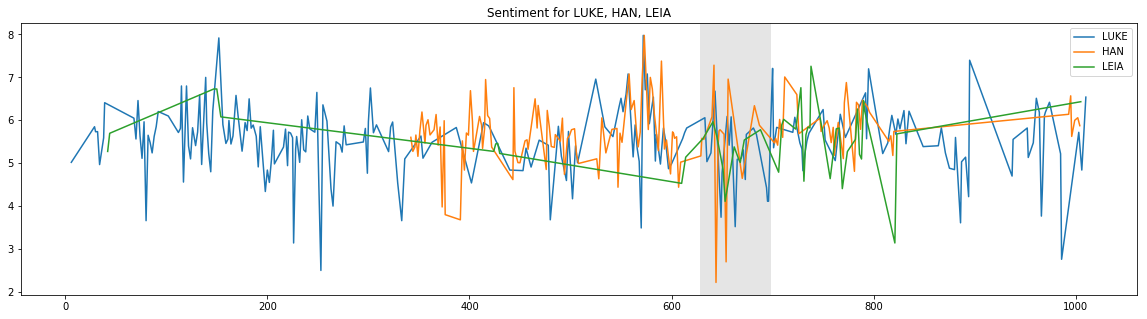

In [14]:
def drawSentimentForCharacters(chars, character_dict):
    plt.figure(figsize=(20,5))
    plt.title("Sentiment for " + ", ".join(chars))
    for char in chars:
        x, y = getSentimentsForCharacter(char, character_dict);
        plt.plot(x,y)
    plt.axvspan(628, 698, facecolor='0.5', alpha=0.2)
    plt.legend(chars)
    plt.show()
drawSentimentForCharacters(["LUKE", "HAN", "LEIA"], character_dictIV)

In [15]:
def characterMeanSTDSentiment(char, character_dict):
    c = getSentimentsForCharacter(char, character_dict)
    if c is None:
        return None
    return np.mean(c[1]), np.std(c[1])

In [16]:
def characterSentimentAcrossMovies(char, list_of_dicts):
#    plt.figure(figsize=(20,5))
    plt.title("Sentiment for " + char + " across movies")
    data = [] 
    for char_dict in list_of_dicts:
        d = getSentimentsForCharacter(char, char_dict)[1]
        data.append(d)
    plt.boxplot(data)
    d2 = [np.mean(a) for a in data]
    d1 = [i+1 for i in range(len(list_of_dicts))]
    plt.plot(d1, d2)    
    plt.show()    

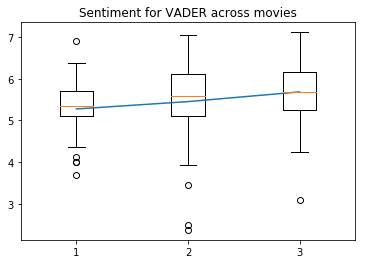

In [24]:
characterSentimentAcrossMovies("VADER", [character_dictIV, character_dictV, character_dictVI])

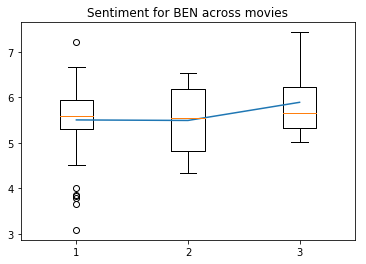

In [18]:
characterSentimentAcrossMovies("BEN", [character_dictIV, character_dictV, character_dictVI])

# Word clouds

In [26]:
from wordcloud import WordCloud
import math
from PIL import Image
from os import path

In [27]:
def tf_idf(doc1, docs, N=2):
    # TF
    fd = nltk.FreqDist(doc1)
    sorted_tokens = [x[0] for x in fd.most_common()]
    tf = np.array([(float(x[1])/len(fd)) for x in fd.most_common()])

    # IDF
    dem_sets = [set(doc1)]
    for doc in docs:
        dem_sets.append(set(doc))
       
    df = np.array([sum([t in s for s in dem_sets]) for t in sorted_tokens])    
    #set1, set2 = set(doc1), set(doc2)
    #df = np.array([(t in set1) + (t in set2) for t in sorted_tokens])
    idf = np.log(N / df)
    
    tf_dict = {}
    for i in range(len(sorted_tokens)):
        tf_dict[sorted_tokens[i]] = tf[i] * idf[i]
    
    # TFIDF
    return tf_dict

In [28]:
def oneLiner(character_dict):
    one_list_to_rule_them_all = []
    for char in character_dict:
        for line in character_dict[char]:
            one_list_to_rule_them_all.append(line[2])
    return " ".join(one_list_to_rule_them_all)

In [29]:
textIV = oneLiner(character_dictIV)
textV = oneLiner(character_dictV)
textVI = oneLiner(character_dictVI)

In [30]:
def generate_wordcloud(doc, docs):
    doc_tokens = tokenize(doc)
    docs_tokens = tokenize(" ".join(docs))
    tfidf = tf_idf(doc_tokens, docs_tokens, N=len(docs))
    
    r2_mask = np.array(Image.open('./Transcripts/rebel.png', 'r'))
    wordcloud = WordCloud(background_color="white", max_words=2000, mask=r2_mask)

    wordcloud.generate_from_frequencies(tfidf)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

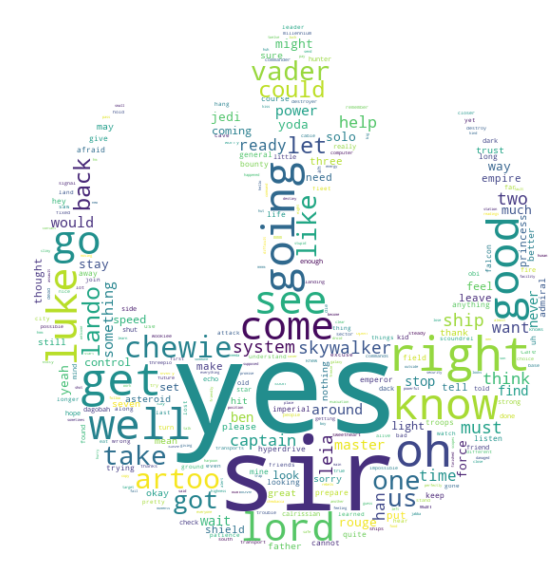

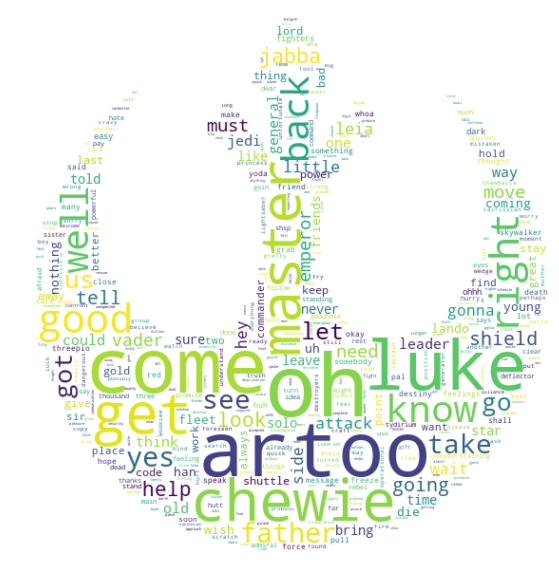

In [33]:
#generate_wordcloud(textIV, [ textV, textVI])
generate_wordcloud(textV, [textIV, textVI])
generate_wordcloud(textVI, [textIV, textV])